In [1]:
import pandas as pd
import numpy as np
import pickle
import re
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

In [2]:
# Display setting for dataframe in notebook
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
decimal = 5
pd.set_option('display.float_format', lambda x: f'%.{decimal}f' % x)

# Import Data

In [3]:
# df_FS = pd.read_pickle("./data_pickle/data_FS.pkl")

In [4]:
df_FS = pd.read_pickle("./data_pickle/data_FS_v1.pkl")

In [5]:
#Check number of 0 value
def miss_checker(data: pd.DataFrame, fig_size=(15,10)):
    nobs = data.shape[0]
    feature = data.columns
    abs_missing = (data==0).sum().to_list()
    ratio_missing = 100*((data==0).sum()/ nobs)
    tab = pd.DataFrame({'Column': feature, 
                        'Abs_missing': abs_missing,
                        'Percent_missing': ratio_missing})
#     tab.sort_values('Abs_missing', inplace=True)
#     tab.plot.barh(x='Column', y='Percent_missing', rot = 0, figsize=fig_size)
    
    return tab

In [6]:
miss_checker(df_FS)

,Column,Abs_missing,Percent_missing
Ticker,Ticker,0,0.00000
ComGroupCode,ComGroupCode,0,0.00000
en_OrganName,en_OrganName,0,0.00000
YearReport_t0,YearReport_t0,0,0.00000
YearReport_t1,YearReport_t1,0,0.00000
YearReport_t2,YearReport_t2,0,0.00000
CurrentAsset_t0,CurrentAsset_t0,0,0.00000
CurrentAsset_t1,CurrentAsset_t1,0,0.00000
CurrentAsset_t2,CurrentAsset_t2,0,0.00000
CashAndEquivalent_t0,CashAndEquivalent_t0,0,0.00000


In [7]:
data = pd.read_excel("./data/config.xlsx", sheet_name=['config_Mscore', 'config_Fscore', 'config_Zscore'])
config_Mscore = data['config_Mscore']
config_Fscore = data['config_Fscore']
config_Zscore = data['config_Zscore']

In [8]:
# def list_columns(df_FS, config):
#     all_columns = set()
#     pattern = re.compile(r"\b\w+\b")

#     for formula in config['formula'][:-1]:
#         columns_used = pattern.findall(formula)
#         columns_used = [col for col in columns_used if col in df_FS.columns]
#         all_columns.update(columns_used)
    
#     return list(all_columns)

In [9]:
def list_columns(df_FS, config):
    denominators = set()
    pattern = re.compile(r"/\s*(\w+(?:\s*\+\s*\w+)*)")

    for formula in config['formula']:
        # Find all denominators in the formula
        matches = pattern.findall(formula)
        for match in matches:
            parts = [part.strip() for part in match.split('+')]
            for part in parts:
                if part in df_FS.columns:
                    denominators.add(part)
    
    return list(denominators)

In [10]:
def winsorize(data, lower_pct, upper_pct):
    data = pd.to_numeric(data, errors='coerce')
    
    lower_limit = data.quantile(lower_pct)
    upper_limit = data.quantile(upper_pct)
    
    data[data < lower_limit] = lower_limit
    data[data > upper_limit] = upper_limit
    
    return data

In [11]:
def calculate_score(df_FS, config, col_denom, lower_pct, upper_pct):
    df_score = pd.DataFrame()
    df_score['Ticker'] = df_FS['Ticker']
    
    df_used = df_FS.copy()
    df_used[col_denom] = df_used[col_denom].fillna(0.00001)
    df_used[col_denom] = df_used[col_denom].replace(0, 0.00001)

    for index, row in config[:-1].iterrows():
        new_col = row['new_col']
        formula = row['formula']
        for old_col in df_used.columns:
            formula = formula.replace(old_col, f"df_used['{old_col}']")
        for old_col in config['new_col']:
            formula = formula.replace(old_col, f"df_score['{old_col}']")
        df_score[new_col] = eval(formula)    
        
    if('ISSUE' in df_score.columns):
        df_score['ISSUE'] = df_score['ISSUE'].apply(lambda x: 1 if x > 0 else 0)
    
    df_score = df_score.fillna(1)
    
    for col in df_score.columns[1:]:
        df_score[col] = winsorize(df_score[col], lower_pct, upper_pct)
    
    score_row = config.iloc[-1]
    new_col = score_row['new_col']
    formula = score_row['formula']
    for old_col in df_score.columns:
        formula = formula.replace(old_col, f"df_score['{old_col}']")
    df_score[new_col] = eval(formula)
    
    cols_to_drop = df_score.filter(regex='_tmp|_t0|_t1').columns
    df_score.drop(columns=cols_to_drop, inplace=True)
    
    return df_score

In [12]:
def his_plot(df_score, score_name, threshold):
    for col in df_score.columns[1:]:
        plt.hist(df_score[col], bins=40, range=[-5, 10])
        if col == score_name:
            plt.axvline(x=threshold, color='red', linestyle='--')
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

# Calculate pre-train score

## Calculate M-score

We have the formular of the M-score

M-score = -4.84 + 0.092*DSRI + 0.528*GMI + 0.404*AQI + 0.892*SGI + 0.115*DEPI - 0.172*SGAI + 4.679*TATA - 0.327*LVGI 

M < -2.22 => Not manipulate

M > -2.22 => Moderate prob of manipulation

M > -1.78 => High prob of manipulation


In [13]:
config_Mscore

,new_col,formula
0,DSRI,(Receivable_ST_t0 / RevenueNet_t0) / (Receivab...
1,AQI,(1- ((CurrentAsset_t0 + PPE_t0 + Investment_L...
2,DEPI,(Depreciation_t1 / (PPE_t1 + Depreciation_t1))...
3,TATA,(OperatingProfit_t0 - CFO_t0) / TotalAssets_t0
4,GMI,((RevenueNet_t1 - CostOfSales_t1) / RevenueNet...
5,SGI,RevenueNet_t0 / RevenueNet_t1
6,SGAI,(SGA_t0 / RevenueNet_t0) / (SGA_t1 / RevenueNe...
7,LVGI,(( Liability_ST_t0 + Debt_LT_t0) / TotalAssets...
8,mscore,(-4.84 + 0.092*DSRI + 0.528*GMI + 0.404*AQI + ...


In [14]:
col_used_mscore = list_columns(df_FS, config_Mscore)
col_used_mscore

['RevenueNet_t0', 'RevenueNet_t1', 'TotalAssets_t1', 'TotalAssets_t0']

In [80]:
miss_checker(df_FS[col_used_mscore])

,Column,Abs_missing,Percent_missing
RevenueNet_t0,RevenueNet_t0,11,0.68879
RevenueNet_t1,RevenueNet_t1,14,0.87664
TotalAssets_t1,TotalAssets_t1,0,0.00000
TotalAssets_t0,TotalAssets_t0,0,0.00000


In [15]:
df_Mscore = calculate_score(df_FS, config_Mscore, col_used_mscore, lower_pct=0.01, upper_pct=0.98)
df_Mscore.describe()

,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,mscore
count,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000
mean,1.21248,1.55704,1.17035,-0.01013,0.99518,1.07800,1.11100,1.05022,-3.05968
std,1.02667,2.36445,0.83628,0.12517,0.07454,0.60643,0.68228,0.33110,1.22533
min,0.00715,0.04138,0.00000,-0.43771,0.59849,0.05629,-0.92528,0.26549,-6.26548
25%,0.72894,0.86893,0.97902,-0.06490,0.98372,0.80058,0.84910,0.91508,-3.66814
50%,0.98646,1.03483,1.03063,-0.00955,1.00090,0.96136,1.01643,1.01259,-3.28392
75%,1.30795,1.31552,1.14647,0.04521,1.01476,1.16753,1.21146,1.11883,-2.76308
max,6.30606,15.66364,6.13837,0.32827,1.19572,3.73879,4.15678,2.42235,5.32212


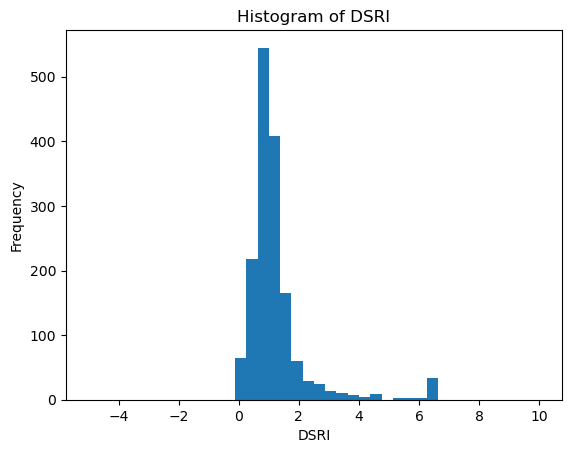

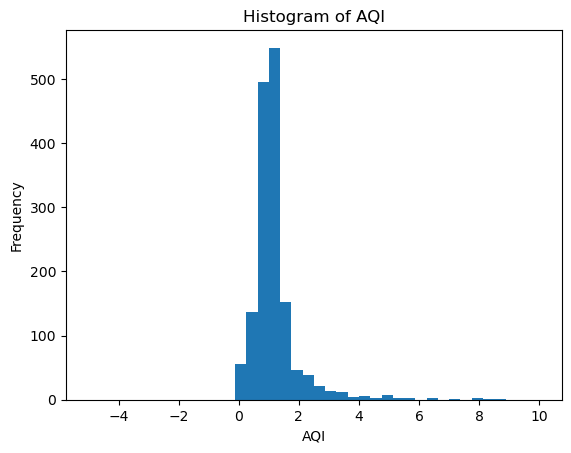

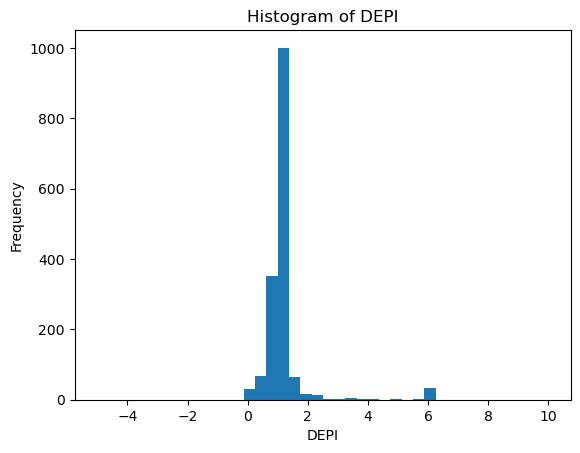

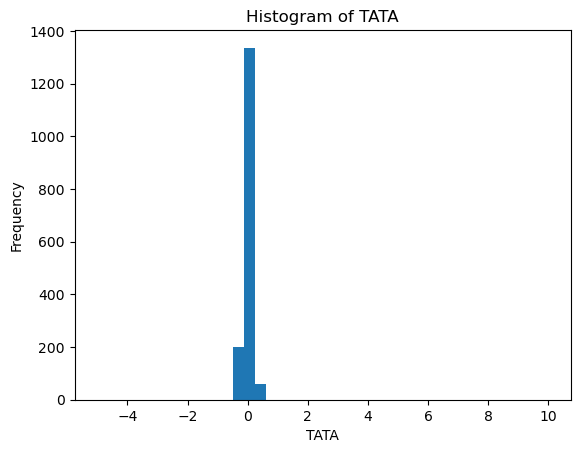

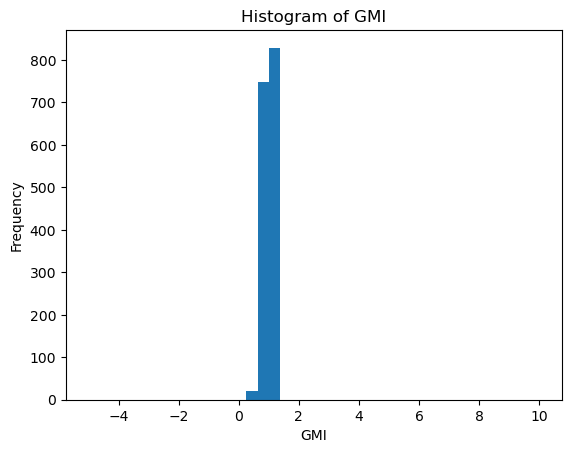

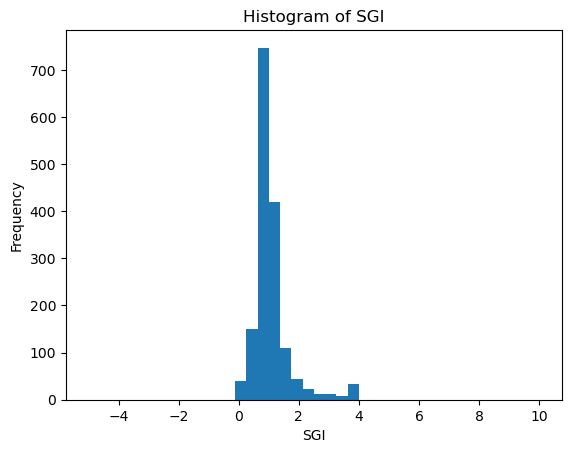

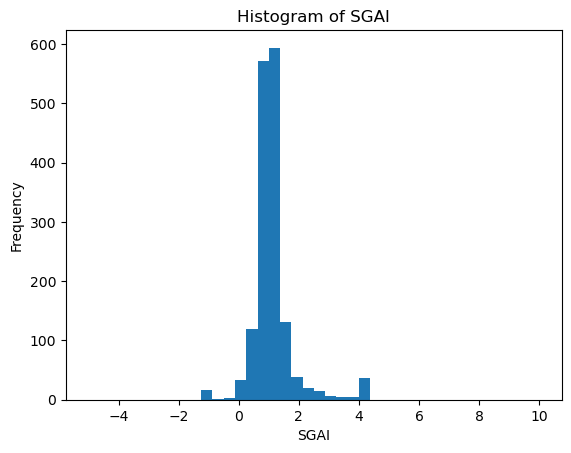

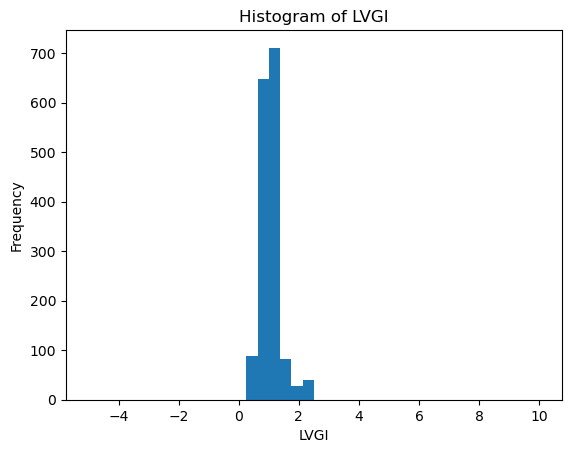

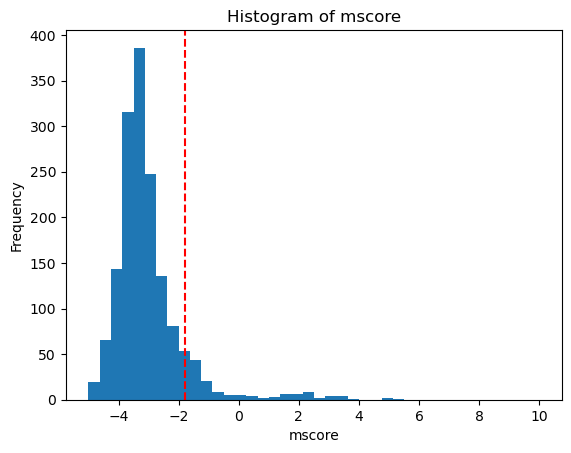

In [16]:
his_plot(df_Mscore, 'mscore', -1.78)

In [17]:
flagged_Mscore = df_Mscore[df_Mscore['mscore'] > -1.78].sort_values(by='mscore', ascending=False,ignore_index=True)
print(len(flagged_Mscore))
print(len(flagged_Mscore) / len(df_Mscore))
flagged_Mscore.head()

133
0.08328115216030056


,Ticker,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,mscore
0,HKT,0.10298,15.55707,1.17776,0.04366,1.01715,3.73879,0.29119,0.89935,5.32212
1,ILA,0.12421,15.66364,3.95921,-0.01758,1.02740,3.73879,0.45545,2.42235,4.87962
2,TOP,0.60532,15.66364,1.32337,-0.07446,1.18216,3.73879,1.13004,0.99773,4.78616
3,DST,4.06513,15.66364,0.76274,0.28718,1.01968,0.84700,0.54091,1.92486,3.86496
4,TV6,1.32334,15.66364,1.05406,0.27886,1.01266,0.62872,1.50539,1.44217,3.40086


## Calculate F-score

pre_val = - 7.893 + 0.790 x RSST + 2.518 x ΔREC + 1.191 x ΔINV + 1.979 x SOFTASSETS + 0.171 x ΔCASHSALES - 0.932 x ΔROA + 1.029 x ISSUE

prob = e^pre_val / (1+e^pre_val)

unconditional_prob = 494/(132967+494) = 0.0037

fscore = prob / unconditional_prob

F > 2.45 => Very high prob

1.85 < F < 2.45 => High prob 

1 < F < 1.85 => Moderate

F < 1 => Not manipulate

In [18]:
config_Fscore

,new_col,formula
0,avg_TA_t0,(TotalAssets_t0 + TotalAssets_t1) / 2
1,avg_TA_t1,(TotalAssets_t1 + TotalAssets_t2) / 2
2,WC_t0,(CurrentAsset_t0 - Cash_t0 - Investment_ST_t0)...
3,WC_t1,(CurrentAsset_t1 - Cash_t1 - Investment_ST_t1)...
4,WC_tmp,WC_t0 - WC_t1
5,NCO_t0,(TotalAssets_t0 - CurrentAsset_t0 - Prepaid_LT...
6,NCO_t1,(TotalAssets_t1 - CurrentAsset_t1 - Prepaid_LT...
7,NCO_tmp,NCO_t0 - NCO_t1
8,FIN_t0,(Investment_ST_t0 + Investment_LT_t0) - (Debt...
9,FIN_t1,(Investment_ST_t1 + Investment_LT_t1) - (Debt...


In [19]:
col_used_fscore = list_columns(df_FS, config_Fscore)
col_used_fscore

['RevenueNet_t0', 'RevenueNet_t1', 'TotalAssets_t0']

In [82]:
miss_checker(df_FS[col_used_fscore])

,Column,Abs_missing,Percent_missing
RevenueNet_t0,RevenueNet_t0,11,0.68879
RevenueNet_t1,RevenueNet_t1,14,0.87664
TotalAssets_t0,TotalAssets_t0,0,0.00000


In [20]:
df_Fscore = calculate_score(df_FS, config_Fscore, col_used_fscore, lower_pct=0.00, upper_pct=1)
df_Fscore.describe()

,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE,pre_val
count,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000
mean,-0.03597,-0.01335,-0.01594,0.68931,66218379744663.59375,-0.00562,0.00564,11323342936330.87695
std,0.21223,0.14506,0.09960,0.24021,2647319679617330.50000,0.14119,0.07488,452691665214562.68750
min,-3.18683,-1.06007,-0.80160,0.00732,-50355067918692.32812,-3.68183,0.00000,-8610716614102.85742
25%,-0.07385,-0.04565,-0.03561,0.54258,0.88192,-0.01995,0.00000,-6.87975
50%,-0.01594,-0.00376,-0.00084,0.74630,0.99468,-0.00123,0.00000,-6.40534
75%,0.02148,0.03203,0.00747,0.88421,1.05376,0.01331,0.00000,-6.01288
max,2.91447,0.92796,0.77457,0.99993,105793425143884304.00000,2.17392,1.00000,18090675699604212.00000


In [21]:
df_Fscore['fscore'] = (np.exp(df_Fscore['pre_val']) / (1 + np.exp(df_Fscore['pre_val']))) / 0.0037
df_Fscore.describe()

/Users/linhdo/anaconda3/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE,pre_val,fscore
count,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000,1595.00000
mean,-0.03597,-0.01335,-0.01594,0.68931,66218379744663.59375,-0.00562,0.00564,11323342936330.87695,1.59206
std,0.21223,0.14506,0.09960,0.24021,2647319679617330.50000,0.14119,0.07488,452691665214562.68750,15.68271
min,-3.18683,-1.06007,-0.80160,0.00732,-50355067918692.32812,-3.68183,0.00000,-8610716614102.85742,0.00000
25%,-0.07385,-0.04565,-0.03561,0.54258,0.88192,-0.01995,0.00000,-6.87975,0.27764
50%,-0.01594,-0.00376,-0.00084,0.74630,0.99468,-0.00123,0.00000,-6.40534,0.44456
75%,0.02148,0.03203,0.00747,0.88421,1.05376,0.01331,0.00000,-6.01288,0.65903
max,2.91447,0.92796,0.77457,0.99993,105793425143884304.00000,2.17392,1.00000,18090675699604212.00000,270.27027


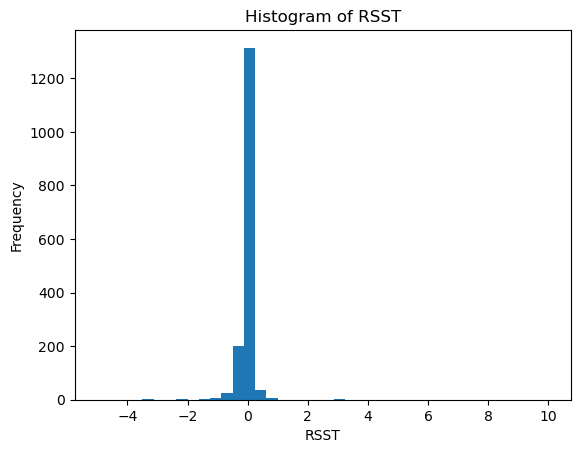

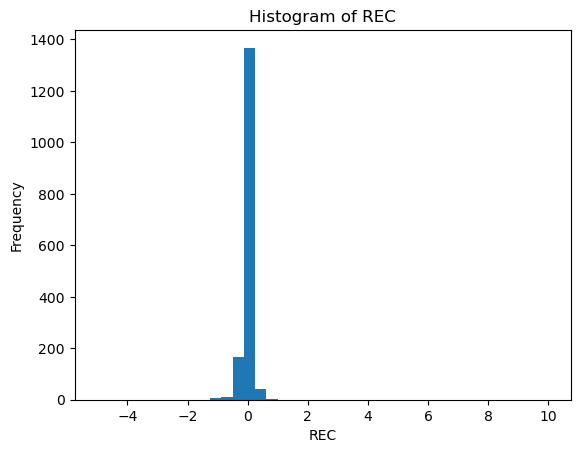

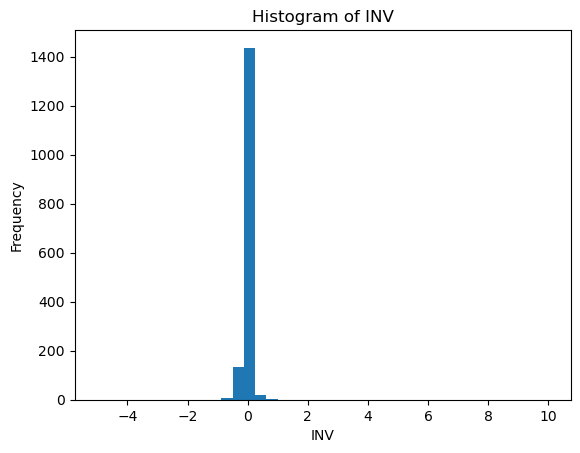

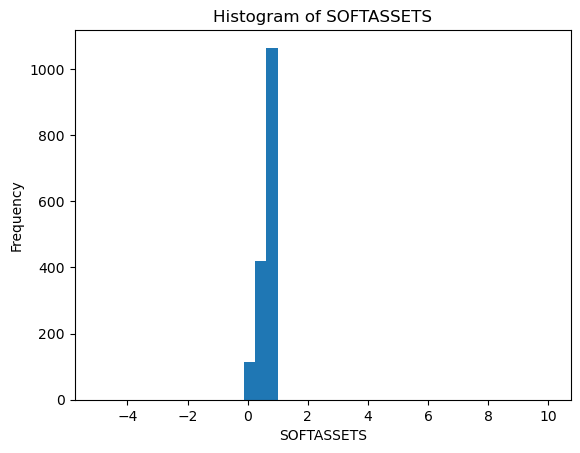

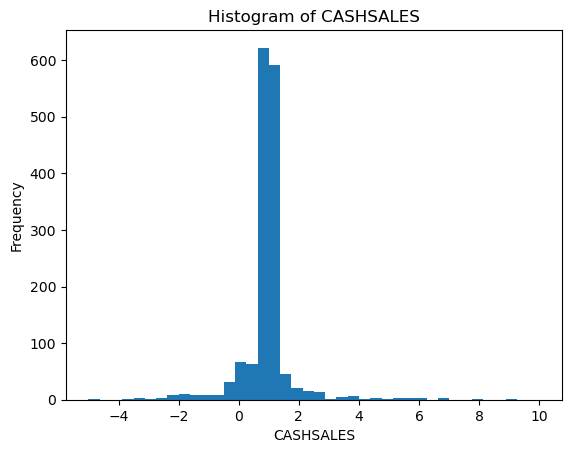

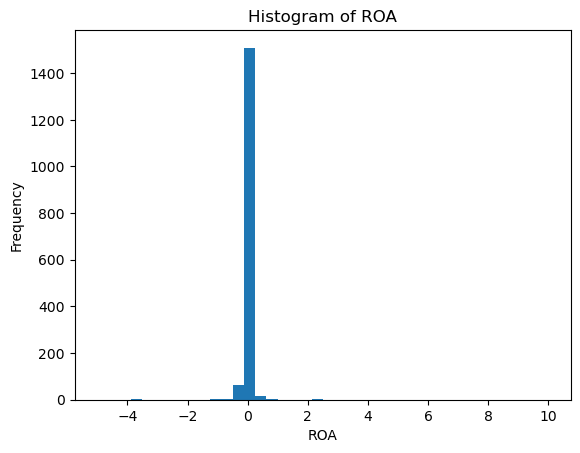

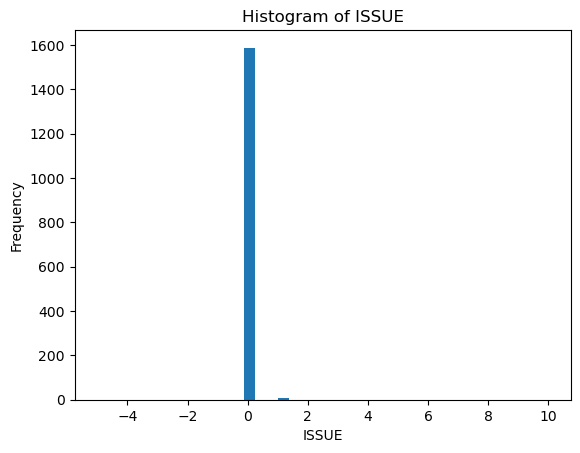

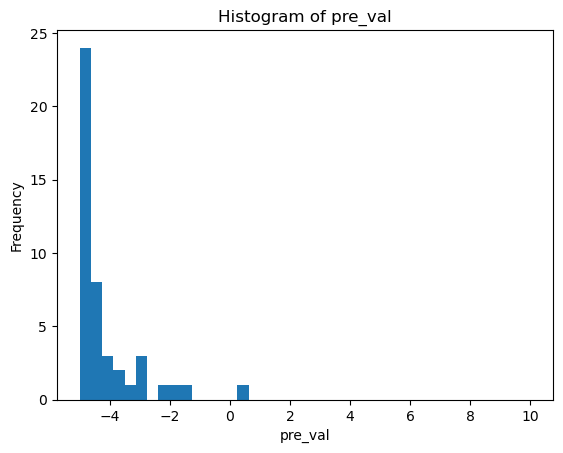

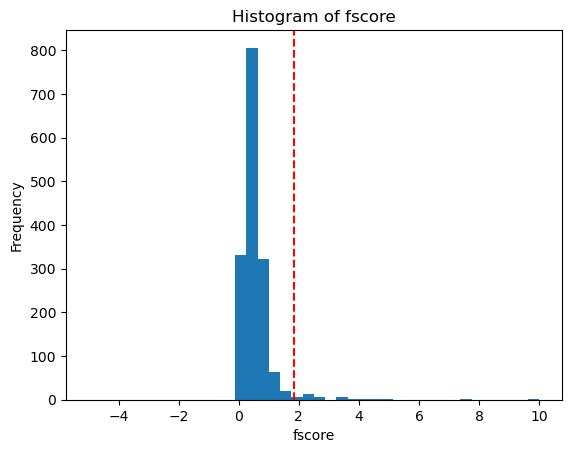

In [22]:
his_plot(df_Fscore, 'fscore', 1.85)

In [23]:
flagged_Fscore = df_Fscore[df_Fscore['fscore'] > 1.85].sort_values(by='fscore', ascending=False,ignore_index=True)
print(len(flagged_Fscore))
print(len(flagged_Fscore) / len(df_Fscore))
flagged_Fscore.head()

49
0.030682529743268627


,Ticker,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE,pre_val,fscore
0,SDA,-0.42893,0.09069,0.01764,0.76470,451.53397,-0.07202,0,70.81029,270.27027
1,CH5,-0.03612,-0.01086,0.01824,0.68308,445.95078,0.01171,0,69.67135,270.27027
2,AMD,-0.00248,0.08767,-0.05810,0.90585,203.56815,0.00445,0,28.85530,270.27027
3,PIV,0.00961,0.14528,0.00000,0.99054,174.44788,0.00503,0,24.26659,270.27027
4,TTZ,-0.00303,0.02331,-0.03283,0.82826,115.08257,-0.07289,0,13.51036,270.26990


## Calculate Z-score

Atlam's Z-score -> Bankrupcy probability
The lower the Z-score => higher prob for bankruptcy

Z-score = 3.25 + (A * 6.72) + (C * 1.05) + (D * 6.56) + (E * 3.26)

Distress  Zone (Z <1.1)

Safe Zone (Z  > 2.6)

Grey Zone (1.1 <= Z <= 2.6)

In [24]:
config_Zscore

,new_col,formula
0,WC/TA,(CurrentAsset_t0 - Liability_ST_t0) / TotalAs...
1,RE/TA,ProfitUndistributed_t0 / TotalAssets_t0
2,BV/TL,TotalEquity_t0 / TotalLiability_t0
3,EBIT/TA,OperatingProfit_t0 / TotalAssets_t0
4,zscore,(3.25 + (EBIT/TA * 6.72) + (BV/TL * 1.05) + (...


In [25]:
col_used_zscore = list_columns(df_FS, config_Zscore)
col_used_zscore

['TotalAssets_t0', 'TotalLiability_t0']

In [83]:
miss_checker(df_FS[col_used_zscore])

,Column,Abs_missing,Percent_missing
TotalAssets_t0,TotalAssets_t0,0,0.00000
TotalLiability_t0,TotalLiability_t0,0,0.00000


In [26]:
df_Zscore = calculate_score(df_FS, config_Zscore, col_used_zscore, lower_pct=0.01, upper_pct=0.98)
df_Zscore.describe()

,WC/TA,RE/TA,BV/TL,EBIT/TA,zscore
count,1597.00000,1597.00000,1597.00000,1597.00000,1597.00000
mean,0.15646,-0.05902,2.47506,0.04562,6.98939
std,0.39720,0.57038,4.16310,0.07665,6.89976
min,-2.43502,-4.33844,-0.66567,-0.22438,-29.07385
25%,0.03010,0.00595,0.46060,0.00563,4.38300
50%,0.16491,0.04425,1.00921,0.03899,6.03109
75%,0.36414,0.10108,2.42145,0.08748,8.96785
max,0.79301,0.34866,21.60266,0.24000,33.01572


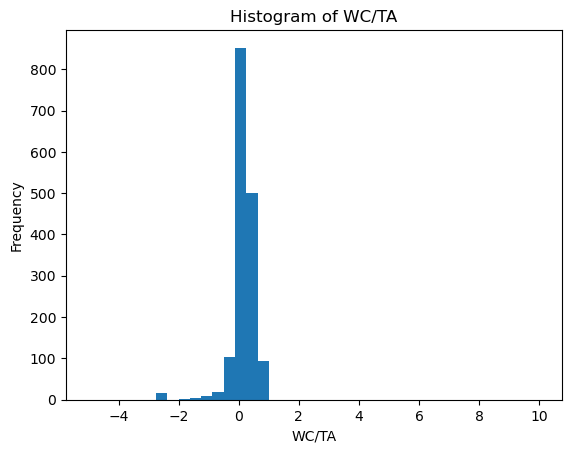

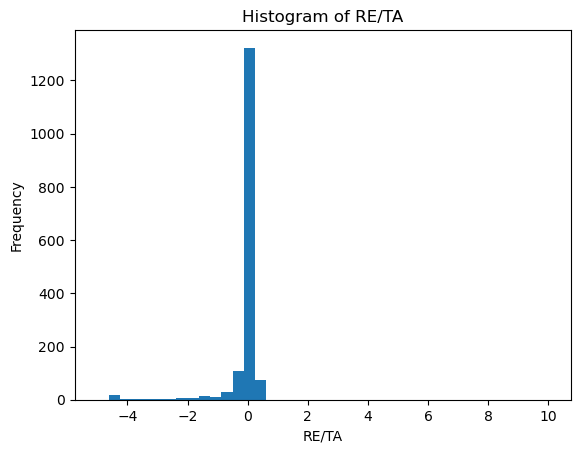

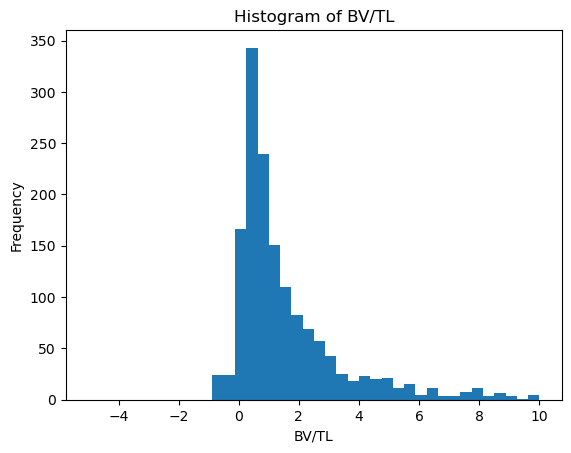

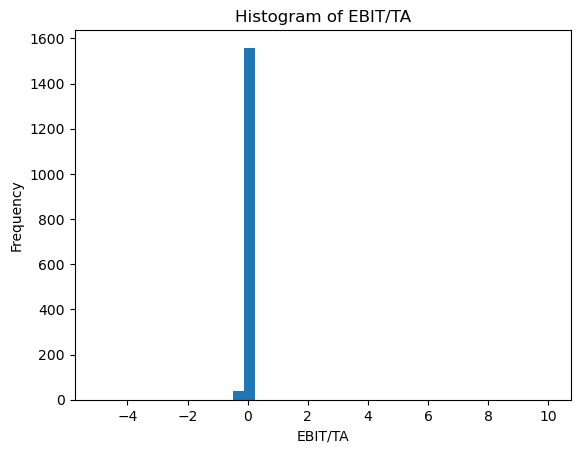

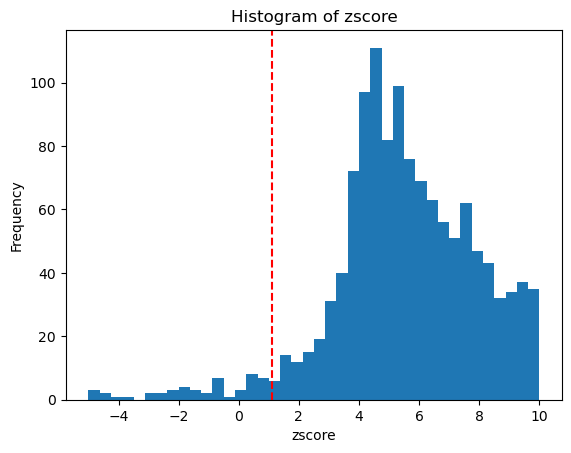

In [27]:
his_plot(df_Zscore, 'zscore', 1.1)

In [28]:
flagged_Zscore = df_Zscore[df_Zscore['zscore'] < 1.1].sort_values(by='zscore', ascending=True, ignore_index=True)
print(len(flagged_Zscore))
print(len(flagged_Zscore) / len(df_Zscore))
flagged_Zscore.head()

94
0.058860363180964305


,Ticker,WC/TA,RE/TA,BV/TL,EBIT/TA,zscore
0,X77,-2.43502,-4.33844,-0.66567,-0.22438,-29.07385
1,ATA,-2.43502,-4.33844,-0.66567,-0.19327,-28.86482
2,NOS,-2.43502,-4.33844,-0.66567,-0.16698,-28.68814
3,FPC,-2.43502,-4.33844,-0.66567,-0.16104,-28.64820
4,CAD,-2.43502,-4.33844,-0.66567,-0.02618,-27.74195


In [29]:
with pd.ExcelWriter('./data/features_list.xlsx', engine='xlsxwriter') as writer:
    df_Mscore.to_excel(writer, sheet_name='Mscore', index=False)
    df_Fscore.to_excel(writer, sheet_name='Fscore', index=False)
    df_Zscore.to_excel(writer, sheet_name='Zscore', index=False)

In [30]:
with pd.ExcelWriter('./data/flagged_list.xlsx', engine='xlsxwriter') as writer:
    flagged_Mscore.to_excel(writer, sheet_name='Mscore', index=False)
    flagged_Fscore.to_excel(writer, sheet_name='Fscore', index=False)
    flagged_Zscore.to_excel(writer, sheet_name='Zscore', index=False)

# PRIDIT Analysis

In [31]:
import scipy
from scipy.stats import norm
from sklearn.decomposition import PCA
from numpy import linalg as LA

## Calculate the cumulative distribution for each variable/column
For each row/column, calculate the ratio of the rows in that column which are >= the current row

In [32]:
def cal_cumm_dist(dfraw):
    length = len(dfraw)
    
    col_to_process = dfraw.columns[1:-1]

    df_cumm_dist = dfraw.copy()

    df_cumm_dist[col_to_process] = dfraw[col_to_process].apply(
        lambda y: y.apply(
            lambda x: ((sum(x >= y)) / length)
        )
    )
    return df_cumm_dist

## Calculate the RIDIT Scores 
B = pi' - (1-pi)
where pi' is the cumm dist of the next ranked value

In [33]:
#nextmax gets the next ranked value relative to the current value 
def nextmax(x,col1):
    z = col1[col1<x]
    return max(z) if len(z) != 0 else 0

def cal_ridit(df_cumm_dist):
    col_to_process = df_cumm_dist.columns[1:-1]
    df_F1= pd.DataFrame(columns = col_to_process)
    i = 'LVF'
    for i in col_to_process:
        #Sort on the cumm dist values to rank order them 
        B_temp = df_cumm_dist[i].sort_values(ascending = False)

        # Used the ranked values to find next highet cumm dist score
        f_next_arr = [nextmax(x,B_temp) for x in B_temp]

        #Created a DF to sort back 
        df_F1_temp = pd.DataFrame(f_next_arr, index = B_temp.index, columns = ['A']).sort_index()
        
        #Assigning values to the F1 data frame 
        df_F1[i] = df_F1_temp['A']
        
    #Calculate the B value 
    B_matrix = -1*(df_F1 - (1 - df_cumm_dist[col_to_process]))

    return df_F1, B_matrix

RIDIT scores transform a variable's score into a set of numerical values in the interval [−1, 1] which reflect the relative abnormality of the particular response  
Assume a binary risk indicator - Yes & NO   

Usually data is heavily skewed - 10% of the data is yes and rest of the 90% is a No. The RIDIT score for Yes would be -0.9 and No would be 0.1  
Note 2 things   
1 - The Yes has a -ve score indicating its an abnormality   
2 - The magnitude is 0.9 vs 0.1 indicating that a Yes is 9X more abnormal than an No  

So RIDIT scores can be interpreted by the direction and magnitude  

## PCA on normalize Ridit score
PCA with  normalized Bmatrix to check and see if the diagonal of the cov martix will be 1 

normalizing by N-1 is giving a diagonal of 1 , when using N with the addition of  ddof=0 the diagonal is 1.11

In [34]:
def pca(B_matrix):
    B_matrix_std = ( B_matrix-B_matrix.mean() ) / B_matrix.std()

    pca = PCA()
    pca.fit(B_matrix_std)
    A_1 = pca.get_covariance()
    
    print("correlation matrix  ")
    print(A_1)
    
    lam, eignvec = LA.eig(A_1)
    print("Eigen values - lambda " , np.round(lam,4))
    print("Eigen vector  ")
    print(np.round(eignvec,4))
    
    return A_1, lam, eignvec

## The W calculates the PRIDIT weights 
These weights correspond to the variables & are directly comparable 

Calculate the W values with the formula w = Sqrt lambda * v i.e. Sqrt(eigen value) * Eigen vector

Pick the eigen value/vector set which explains the max variance 

In [35]:
def cal_weight(B_matrix, lam, eignvec):
    # Calculate weight vector
    maxindex = np.where(lam == max(lam))[0][0]
    w = np.sqrt(lam[maxindex]) * eignvec[:,maxindex]
    
    df_weight = pd.DataFrame({
    'Feature Name': B_matrix.columns,
    'Weight': w
    })
    
    return w, df_weight

## Get the final ranking df 

In [36]:
def cal_ranking(dfraw, B_matrix, w, lam):
    #normalizing matrices to make them 0 sum 
    Bsq = B_matrix.T.dot(B_matrix)
    bsqrt = np.sqrt(np.diag(Bsq))

    normed_matrix = B_matrix/bsqrt

    #Normalized matrix * Weight matrix W/ divided by the lambda value to get the weights matrix 
    s_matrix = normed_matrix.dot(w)/lam[1]
    
    dfinal = dfraw.copy()
    dfinal['pridit_ranking'] = s_matrix
    
    return dfinal

# PRIDIT score corresponding pre-train score model

In [37]:
import scipy
from scipy.stats import norm
from sklearn.decomposition import PCA
from numpy import linalg as LA

## PRIDIT Analysis for Mscore features

In [38]:
df_Mscore

,Ticker,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,mscore
0,A32,0.96777,0.99271,1.00000,0.07756,0.99968,1.12064,0.86638,0.91858,-2.79397
1,AAA,1.64481,0.75879,1.19164,-0.03016,1.00294,0.56521,0.80154,1.15014,-3.86643
2,AAM,2.45637,0.94042,1.14033,0.03989,0.97273,0.90140,1.40563,2.42235,-3.63254
3,AAS,2.33362,15.66364,0.96160,-0.05310,0.75373,0.52516,0.89533,1.78564,1.69346
4,AAT,1.04716,0.59763,1.00000,0.03934,1.00175,0.60675,1.31566,0.81051,-3.62432
...,...,...,...,...,...,...,...,...,...,...
1592,XPH,0.91159,1.17857,0.94157,0.12086,1.06045,0.96749,0.71278,1.48537,-2.79161
1593,YBC,0.83668,0.74727,1.12244,0.06558,1.00181,0.97785,1.09667,1.03548,-3.15123
1594,YBM,0.83518,1.08613,0.93192,0.01447,1.03980,0.86242,1.22813,1.00254,-3.37026
1595,YEG,0.62918,2.64121,1.23726,0.13826,0.99902,1.12887,0.81080,1.04685,-1.87321


In [39]:
mscore_cumm_dist = cal_cumm_dist(df_Mscore)
mscore_cumm_dist

,Ticker,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,mscore
0,A32,0.48341,0.41515,0.44834,0.82655,0.47464,0.72198,0.26988,0.25798,-2.79397
1,AAA,0.86162,0.16844,0.80338,0.39887,0.55041,0.09080,0.19537,0.78585,-3.86643
2,AAM,0.93175,0.33813,0.74014,0.72887,0.18347,0.39574,0.84534,1.00000,-3.63254
3,AAS,0.92486,1.00000,0.22793,0.30307,0.01816,0.07639,0.30056,0.96180,1.69346
4,AAT,0.57984,0.11083,0.44834,0.72511,0.52035,0.10833,0.81403,0.13400,-3.62432
...,...,...,...,...,...,...,...,...,...,...
1592,XPH,0.42016,0.67001,0.20100,0.89230,0.92736,0.50971,0.14402,0.92862,-2.79161
1593,YBC,0.34627,0.16093,0.70695,0.79712,0.52223,0.54101,0.63118,0.57921,-3.15123
1594,YBM,0.34502,0.56982,0.19161,0.62304,0.88478,0.34126,0.76080,0.46650,-3.37026
1595,YEG,0.18034,0.92924,0.84847,0.91108,0.46149,0.72887,0.20351,0.61115,-1.87321


In [40]:
mscore_F1, mscore_Bmatrix = cal_ridit(mscore_cumm_dist)
mscore_F1

,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI
0,0.48278,0.41453,0.28178,0.82592,0.47401,0.72135,0.26925,0.25736
1,0.86099,0.16781,0.80276,0.39825,0.54978,0.09017,0.19474,0.78522
2,0.93112,0.33751,0.73951,0.72824,0.18284,0.39512,0.84471,0.97996
3,0.92423,0.97996,0.22730,0.30244,0.01753,0.07577,0.29994,0.96118
4,0.57921,0.11021,0.28178,0.72448,0.51972,0.10770,0.81340,0.13338
...,...,...,...,...,...,...,...,...
1592,0.41954,0.66938,0.20038,0.89167,0.92674,0.50908,0.14339,0.92799
1593,0.34565,0.16030,0.70632,0.79649,0.52160,0.54039,0.63056,0.57858
1594,0.34440,0.56919,0.19098,0.62242,0.88416,0.34064,0.76018,0.46587
1595,0.17971,0.92862,0.84784,0.91046,0.46086,0.72824,0.20288,0.61052


In [41]:
mscore_Bmatrix

,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI
0,0.03381,0.17032,0.26988,-0.65247,0.05135,-0.44333,0.46086,0.48466
1,-0.72260,0.66374,-0.60614,0.20288,-0.10019,0.81904,0.60989,-0.57107
2,-0.86287,0.32436,-0.47965,-0.45711,0.63369,0.20914,-0.69004,-0.97996
3,-0.84909,-0.97996,0.54477,0.39449,0.96431,0.84784,0.39950,-0.92298
4,-0.15905,0.77896,0.26988,-0.44959,-0.04008,0.78397,-0.62743,0.73262
...,...,...,...,...,...,...,...,...
1592,0.16030,-0.33939,0.59862,-0.78397,-0.85410,-0.01879,0.71259,-0.85661
1593,0.30808,0.67877,-0.41327,-0.59361,-0.04383,-0.08140,-0.26174,-0.15780
1594,0.31058,-0.13901,0.61741,-0.24546,-0.76894,0.31810,-0.52098,0.06763
1595,0.63995,-0.85786,-0.69631,-0.82154,0.07765,-0.45711,0.59361,-0.22167


In [42]:
mscore_A1, mscore_lam, mscore_eignvec = pca(mscore_Bmatrix)

correlation matrix  
[[ 1.00000000e+00 -4.30333069e-02 -7.08664499e-04  7.66606120e-02
  -3.10956065e-02 -4.61355485e-01  3.16922579e-01  4.85300543e-02]
 [-4.30333069e-02  1.00000000e+00 -1.03319912e-01  9.47976947e-03
  -3.23334787e-02 -1.23850505e-01  1.11964460e-01 -9.94547470e-02]
 [-7.08664499e-04 -1.03319912e-01  1.00000000e+00 -1.96707894e-02
   5.99916690e-02  8.83440725e-03  1.67885564e-02  7.02872074e-02]
 [ 7.66606120e-02  9.47976947e-03 -1.96707894e-02  1.00000000e+00
   4.43392025e-02 -7.06188691e-02 -3.59811608e-06  1.24189547e-02]
 [-3.10956065e-02 -3.23334787e-02  5.99916690e-02  4.43392025e-02
   1.00000000e+00  7.99239638e-02  1.54560488e-01 -6.53578133e-02]
 [-4.61355485e-01 -1.23850505e-01  8.83440725e-03 -7.06188691e-02
   7.99239638e-02  1.00000000e+00 -5.38266138e-01  1.43036051e-01]
 [ 3.16922579e-01  1.11964460e-01  1.67885564e-02 -3.59811608e-06
   1.54560488e-01 -5.38266138e-01  1.00000000e+00 -8.96118478e-02]
 [ 4.85300543e-02 -9.94547470e-02  7.02872074e-0

In [43]:
mscore_w, mscore_weight = cal_weight(mscore_Bmatrix, mscore_lam, mscore_eignvec)
mscore_weight

,Feature Name,Weight
0,DSRI,0.68596
1,AQI,0.20259
2,DEPI,-0.03191
3,TATA,0.12454
4,GMI,0.04447
5,SGI,-0.86094
6,SGAI,0.78499
7,LVGI,-0.19846


In [44]:
mscore_w  = (-1) * mscore_w

In [45]:
pridit_mscore = cal_ranking(df_Mscore, mscore_Bmatrix, mscore_w, mscore_lam)
pridit_mscore

,Ticker,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,mscore,pridit_ranking
0,A32,0.96777,0.99271,1.00000,0.07756,0.99968,1.12064,0.86638,0.91858,-2.79397,-0.07069
1,AAA,1.64481,0.75879,1.19164,-0.03016,1.00294,0.56521,0.80154,1.15014,-3.86643,0.04970
2,AAM,2.45637,0.94042,1.14033,0.03989,0.97273,0.90140,1.40563,2.42235,-3.63254,0.12216
3,AAS,2.33362,15.66364,0.96160,-0.05310,0.75373,0.52516,0.89533,1.78564,1.69346,0.10758
4,AAT,1.04716,0.59763,1.00000,0.03934,1.00175,0.60675,1.31566,0.81051,-3.62432,0.15235
...,...,...,...,...,...,...,...,...,...,...,...
1592,XPH,0.91159,1.17857,0.94157,0.12086,1.06045,0.96749,0.71278,1.48537,-2.79161,-0.07236
1593,YBC,0.83668,0.74727,1.12244,0.06558,1.00181,0.97785,1.09667,1.03548,-3.15123,-0.02085
1594,YBM,0.83518,1.08613,0.93192,0.01447,1.03980,0.86242,1.22813,1.00254,-3.37026,0.06823
1595,YEG,0.62918,2.64121,1.23726,0.13826,0.99902,1.12887,0.81080,1.04685,-1.87321,-0.12505


In [46]:
pridit_mscore.sort_values(by='pridit_ranking',ascending = True)

,Ticker,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,mscore,pridit_ranking
152,BVG,0.00715,0.06607,1.00000,-0.13899,0.59849,3.73879,0.00000,1.57632,-2.21244,-0.31925
1251,TAN,0.04341,0.37247,1.03816,0.00653,0.82960,3.73879,0.04502,2.42235,-1.56242,-0.30454
1452,VE9,0.35040,0.63167,0.87398,-0.29254,0.87118,3.73879,0.22627,1.52918,-2.56481,-0.30225
642,ICG,0.10713,0.78248,6.13837,-0.07910,1.08442,3.73879,0.12481,2.42235,-1.08422,-0.30163
144,BTH,0.00715,0.20981,1.00000,-0.04403,0.64180,3.73879,0.04002,1.03835,-1.51817,-0.29474
...,...,...,...,...,...,...,...,...,...,...,...
1032,PV2,5.92984,1.11190,1.48730,0.07042,1.19572,0.11013,4.15678,0.70895,-3.56191,0.29364
1013,PSI,4.74120,1.63353,1.23732,0.26340,1.07630,0.34711,1.90661,0.72123,-2.05499,0.29477
526,HD2,6.30606,1.64021,1.07895,-0.11178,1.19572,0.05629,4.15678,0.26549,-4.11638,0.29509
50,APS,6.30606,2.79281,1.20592,0.25607,0.67884,0.21162,4.15678,0.34758,-2.07616,0.30781


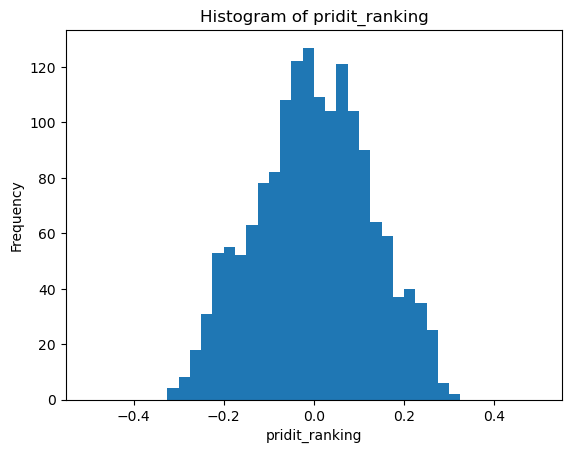

In [47]:
plt.hist(pridit_mscore['pridit_ranking'], bins=40, range=[-0.5, 0.5])
# threshold
# plt.axvline(x=threshold, color='red', linestyle='--')
plt.title(f'Histogram of pridit_ranking')
plt.xlabel('pridit_ranking')
plt.ylabel('Frequency')
plt.show()

In [48]:
threshold = len(flagged_Mscore) 
flagged_pridit_mscore = pridit_mscore.sort_values(by='pridit_ranking',ascending = True)[:threshold]
flagged_pridit_mscore

,Ticker,DSRI,AQI,DEPI,TATA,GMI,SGI,SGAI,LVGI,mscore,pridit_ranking
152,BVG,0.00715,0.06607,1.00000,-0.13899,0.59849,3.73879,0.00000,1.57632,-2.21244,-0.31925
1251,TAN,0.04341,0.37247,1.03816,0.00653,0.82960,3.73879,0.04502,2.42235,-1.56242,-0.30454
1452,VE9,0.35040,0.63167,0.87398,-0.29254,0.87118,3.73879,0.22627,1.52918,-2.56481,-0.30225
642,ICG,0.10713,0.78248,6.13837,-0.07910,1.08442,3.73879,0.12481,2.42235,-1.08422,-0.30163
144,BTH,0.00715,0.20981,1.00000,-0.04403,0.64180,3.73879,0.04002,1.03835,-1.51817,-0.29474
665,ING,0.00715,0.92897,1.00000,-0.05182,1.19572,3.73879,-0.00000,2.42235,-1.41729,-0.29126
1239,SVN,0.00715,0.24107,0.09427,0.04380,1.05401,3.73879,0.00313,2.42235,-1.42732,-0.28976
1034,PVB,0.33672,0.92277,1.12910,-0.28842,1.19572,3.73879,0.12963,1.55760,-2.22118,-0.28968
1080,RCD,0.20427,1.02404,1.00000,-0.14602,0.94890,3.73879,0.23432,1.31159,-1.60888,-0.28735
995,PPE,0.22762,1.00000,1.00000,0.00544,0.97576,3.73879,-0.06799,1.58001,-0.92938,-0.27999


## PRIDIT Analysis for Fscore features

In [49]:
# df_Fscore
# df_Fscore.drop(columns='pre_val', inplace=True)

In [50]:
df_Fscore

,Ticker,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE,pre_val,fscore
0,A32,0.10974,0.01868,-0.00349,0.66435,1.00673,0.01850,0,-6.29378,0.49848
1,AAA,-0.05532,-0.01360,-0.00544,0.62553,0.89798,-0.00068,0,-6.58532,0.37259
2,AAM,-0.01297,0.04579,0.16780,0.83726,0.91047,-0.05918,0,-5.72033,0.88322
3,AAS,-0.50930,0.01683,0.00000,0.60742,0.86904,-0.18822,0,-6.72685,0.32348
4,AAT,-0.22272,-0.09916,-0.00106,0.46514,0.96184,-0.01035,0,-7.22525,0.19660
...,...,...,...,...,...,...,...,...,...,...
1592,XPH,0.05843,-0.01392,-0.02652,0.76099,1.07057,0.08148,0,-6.30034,0.49522
1593,YBC,-0.00718,-0.04690,0.02122,0.53618,1.05866,-0.00051,0,-6.74888,0.31644
1594,YBM,-0.03809,-0.10541,0.05898,0.50196,1.07996,-0.00385,0,-6.93664,0.26232
1595,YEG,-0.02006,-0.22268,0.04704,0.96994,20.69413,-0.15352,0,-2.81224,15.31524


In [51]:
fscore_cumm_dist = cal_cumm_dist(df_Fscore)
fscore_cumm_dist

,Ticker,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE,pre_val,fscore
0,A32,0.91922,0.68128,0.44834,0.38948,0.57984,0.79649,0.99436,0.57358,0.49848
1,AAA,0.30056,0.40952,0.41703,0.33438,0.26800,0.51659,0.99436,0.39574,0.37259
2,AAM,0.52223,0.79837,0.97683,0.66187,0.28053,0.10708,0.99436,0.88353,0.88322
3,AAS,0.02066,0.67376,0.61177,0.31434,0.24045,0.02317,0.99436,0.31997,0.32348
4,AAT,0.07577,0.14652,0.49343,0.18785,0.36819,0.33813,0.99436,0.12899,0.19660
...,...,...,...,...,...,...,...,...,...,...
1592,XPH,0.85473,0.40827,0.28366,0.52035,0.78334,0.95116,0.99436,0.56982,0.49522
1593,YBC,0.56731,0.24546,0.82279,0.24546,0.76018,0.52286,0.99436,0.30432,0.31644
1594,YBM,0.36631,0.13901,0.90983,0.21666,0.79211,0.44208,0.99436,0.22981,0.26232
1595,YEG,0.47151,0.06011,0.88791,0.92235,0.99061,0.03256,0.99436,0.99311,15.31524


In [52]:
fscore_F1, fscore_Bmatrix = cal_ridit(fscore_cumm_dist)
fscore_F1

,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE,pre_val
0,0.91860,0.68065,0.44771,0.38885,0.57921,0.79587,0.00000,0.57295
1,0.29994,0.40889,0.41641,0.33375,0.26738,0.51597,0.00000,0.39512
2,0.52160,0.79775,0.97621,0.66124,0.27990,0.10645,0.00000,0.88291
3,0.02004,0.67314,0.53976,0.31371,0.23982,0.02254,0.00000,0.31935
4,0.07514,0.14590,0.49280,0.18723,0.36756,0.33751,0.00000,0.12837
...,...,...,...,...,...,...,...,...
1592,0.85410,0.40764,0.28303,0.51972,0.78272,0.95053,0.00000,0.56919
1593,0.56669,0.24483,0.82217,0.24483,0.75955,0.52223,0.00000,0.30369
1594,0.36569,0.13838,0.90920,0.21603,0.79148,0.44145,0.00000,0.22918
1595,0.47088,0.05949,0.88729,0.92173,0.98998,0.03193,0.00000,0.99249


In [53]:
fscore_Bmatrix

,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE,pre_val
0,-0.83782,-0.36193,0.10394,0.22167,-0.15905,-0.59236,0.00564,-0.14652
1,0.39950,0.18159,0.16656,0.33187,0.46462,-0.03256,0.00564,0.20914
2,-0.04383,-0.59612,-0.95304,-0.32311,0.43957,0.78647,0.00564,-0.76644
3,0.95930,-0.34690,-0.15153,0.37195,0.51972,0.95429,0.00564,0.36068
4,0.84909,0.70758,0.01378,0.62492,0.26425,0.32436,0.00564,0.74264
...,...,...,...,...,...,...,...,...
1592,-0.70883,0.18410,0.43331,-0.04008,-0.56606,-0.90169,0.00564,-0.13901
1593,-0.13400,0.50971,-0.64496,0.50971,-0.51972,-0.04508,0.00564,0.39198
1594,0.26800,0.72260,-0.81904,0.56731,-0.58359,0.11647,0.00564,0.54101
1595,0.05761,0.88040,-0.77520,-0.84408,-0.98059,0.93550,0.00564,-0.98560


In [54]:
fscore_A1, fscore_lam, fscore_eignvec = pca(fscore_Bmatrix)

correlation matrix  
[[ 1.00000000e+00  2.14489586e-01  1.94725436e-01  3.24463464e-03
   1.59927147e-02  2.76711228e-01  4.57235381e-03  2.62540492e-01]
 [ 2.14489586e-01  1.00000000e+00  6.02567512e-02  4.82270003e-02
  -3.34924520e-01  1.10100981e-01  3.98447975e-02  4.50061769e-01]
 [ 1.94725436e-01  6.02567512e-02  1.00000000e+00  5.22807082e-02
   2.83244406e-02  2.50439168e-02  3.44805339e-02  2.09262174e-01]
 [ 3.24463464e-03  4.82270003e-02  5.22807082e-02  1.00000000e+00
  -1.26041129e-01  9.25591344e-03  1.36081959e-04  7.14361616e-01]
 [ 1.59927147e-02 -3.34924520e-01  2.83244406e-02 -1.26041129e-01
   1.00000000e+00  1.19195871e-01 -1.08139797e-02 -4.84074156e-03]
 [ 2.76711228e-01  1.10100981e-01  2.50439168e-02  9.25591344e-03
   1.19195871e-01  1.00000000e+00 -4.80822921e-03  4.24806848e-02]
 [ 4.57235381e-03  3.98447975e-02  3.44805339e-02  1.36081959e-04
  -1.08139797e-02 -4.80822921e-03  1.00000000e+00  1.10589272e-01]
 [ 2.62540492e-01  4.50061769e-01  2.09262174e-0

In [55]:
fscore_w, fscore_weight = cal_weight(fscore_Bmatrix, fscore_lam, fscore_eignvec)
fscore_weight

,Feature Name,Weight
0,RSST,0.45343
1,REC,0.61632
2,INV,0.32752
3,SOFTASSETS,0.67395
4,CASHSALES,-0.23854
5,ROA,0.20180
6,ISSUE,0.12962
7,pre_val,0.90232


In [56]:
# fscore_w = (-1)*fscore_w

In [57]:
pridit_fscore = cal_ranking(df_Fscore, fscore_Bmatrix, fscore_w, fscore_lam)
pridit_fscore

,Ticker,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE,pre_val,fscore,pridit_ranking
0,A32,0.10974,0.01868,-0.00349,0.66435,1.00673,0.01850,0,-6.29378,0.49848,-0.25659
1,AAA,-0.05532,-0.01360,-0.00544,0.62553,0.89798,-0.00068,0,-6.58532,0.37259,0.26499
2,AAM,-0.01297,0.04579,0.16780,0.83726,0.91047,-0.05918,0,-5.72033,0.88322,-0.63334
3,AAS,-0.50930,0.01683,0.00000,0.60742,0.86904,-0.18822,0,-6.72685,0.32348,0.33598
4,AAT,-0.22272,-0.09916,-0.00106,0.46514,0.96184,-0.01035,0,-7.22525,0.19660,0.78689
...,...,...,...,...,...,...,...,...,...,...,...
1592,XPH,0.05843,-0.01392,-0.02652,0.76099,1.07057,0.08148,0,-6.30034,0.49522,-0.10618
1593,YBC,-0.00718,-0.04690,0.02122,0.53618,1.05866,-0.00051,0,-6.74888,0.31644,0.35149
1594,YBM,-0.03809,-0.10541,0.05898,0.50196,1.07996,-0.00385,0,-6.93664,0.26232,0.54673
1595,YEG,-0.02006,-0.22268,0.04704,0.96994,20.69413,-0.15352,0,-2.81224,15.31524,-0.29232


In [58]:
pridit_fscore.sort_values(by='pridit_ranking',ascending = True)

,Ticker,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE,pre_val,fscore,pridit_ranking
52,ARM,-0.04295,0.40225,0.03365,0.90562,0.30593,-0.00507,1,-3.99573,4.88156,-1.27302
761,LMH,0.27240,0.19579,0.03952,0.99592,0.34404,0.21735,0,-5.31054,1.32837,-1.26269
1277,TDH,0.52623,0.35887,0.14973,0.89753,-0.13959,0.55236,0,-5.15777,1.54638,-1.20785
1217,SSF,0.38475,0.55872,0.00000,0.96776,0.61604,0.57418,0,-4.69679,2.44379,-1.18243
37,AME,0.49377,0.09323,0.06268,0.99000,0.30609,0.00017,0,-5.18212,1.50939,-1.16430
...,...,...,...,...,...,...,...,...,...,...,...
619,HTR,-0.24546,-0.30779,-0.03707,0.51428,1.21828,0.00126,0,-7.68117,0.12465,1.02148
1017,PSW,-0.13036,-0.19512,-0.11429,0.45399,1.01279,-0.15043,0,-7.41158,0.16320,1.04413
871,NGC,-0.08283,-1.06007,0.00148,0.30355,1.58860,-0.22532,0,-9.54356,0.01937,1.05927
308,DDG,-0.27698,-0.31843,-0.00295,0.43057,2.22974,-0.01114,0,-7.67338,0.12563,1.06243


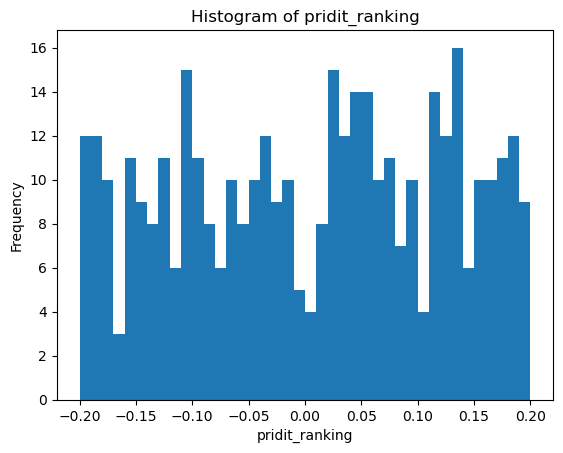

In [59]:
plt.hist(pridit_fscore['pridit_ranking'], bins=40, range=[-0.2, 0.2])
# threshold
# plt.axvline(x=threshold, color='red', linestyle='--')
plt.title(f'Histogram of pridit_ranking')
plt.xlabel('pridit_ranking')
plt.ylabel('Frequency')
plt.show()

In [60]:
threshold = len(flagged_Fscore) 
flagged_pridit_fscore = pridit_fscore.sort_values(by='pridit_ranking',ascending = True)[:threshold]
flagged_pridit_fscore

,Ticker,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE,pre_val,fscore,pridit_ranking
52,ARM,-0.04295,0.40225,0.03365,0.90562,0.30593,-0.00507,1,-3.99573,4.88156,-1.27302
761,LMH,0.27240,0.19579,0.03952,0.99592,0.34404,0.21735,0,-5.31054,1.32837,-1.26269
1277,TDH,0.52623,0.35887,0.14973,0.89753,-0.13959,0.55236,0,-5.15777,1.54638,-1.20785
1217,SSF,0.38475,0.55872,0.00000,0.96776,0.61604,0.57418,0,-4.69679,2.44379,-1.18243
37,AME,0.49377,0.09323,0.06268,0.99000,0.30609,0.00017,0,-5.18212,1.50939,-1.16430
829,MTC,0.95180,0.02508,0.00084,0.69528,0.98459,0.13961,1,-4.63370,2.60140,-1.15131
1452,VE9,0.30007,0.43252,0.00521,0.98385,0.23910,-0.21486,0,-4.37248,3.36827,-1.08823
994,PPC,0.25370,0.14972,0.03096,0.92233,0.98206,0.12093,0,-5.39821,1.21738,-1.07746
699,KLM,0.90164,0.18447,-0.00692,0.93803,0.77551,0.64446,0,-5.33612,1.29498,-1.05759
776,MAC,0.20457,0.16758,0.08801,0.82732,0.62839,0.09013,0,-5.54389,1.05298,-1.04885


## PRIDIT Analysis for Zscore features

In [61]:
df_Zscore

,Ticker,WC/TA,RE/TA,BV/TL,EBIT/TA,zscore
0,A32,0.22653,0.12661,0.98431,0.08632,6.76237
1,AAA,0.08440,0.06637,0.88527,0.04132,5.22722
2,AAM,0.73892,-0.00949,11.61010,-0.07543,19.75009
3,AAS,0.50338,0.04904,1.13682,0.02223,8.05510
4,AAT,0.13864,0.13189,2.74274,0.04110,7.74551
...,...,...,...,...,...,...
1592,XPH,0.34522,-0.16045,21.60266,-0.01499,27.57365
1593,YBC,-0.33153,-0.03946,0.16012,0.04359,1.40760
1594,YBM,0.02570,0.06825,0.69408,0.09270,4.99280
1595,YEG,0.39194,-0.15833,1.74438,-0.17075,5.98909


In [62]:
zscore_cumm_dist = cal_cumm_dist(df_Zscore)
zscore_cumm_dist

,Ticker,WC/TA,RE/TA,BV/TL,EBIT/TA,zscore
0,A32,0.59925,0.81778,0.49405,0.74703,6.76237
1,AAA,0.35942,0.61553,0.46399,0.51284,5.22722
2,AAM,0.97370,0.19286,0.94803,0.05009,19.75009
3,AAS,0.87226,0.53475,0.53413,0.37696,8.05510
4,AAT,0.45711,0.83219,0.78209,0.51096,7.74551
...,...,...,...,...,...,...
1592,XPH,0.72699,0.10645,1.00000,0.13024,27.57365
1593,YBC,0.04446,0.17470,0.07765,0.52912,1.40760
1594,YBM,0.24546,0.62805,0.37946,0.77082,4.99280
1595,YEG,0.78773,0.10833,0.66124,0.01565,5.98909


In [63]:
zscore_F1, zscore_Bmatrix = cal_ridit(zscore_cumm_dist)
zscore_F1

,WC/TA,RE/TA,BV/TL,EBIT/TA
0,0.59862,0.81716,0.49343,0.74640
1,0.35880,0.61490,0.46337,0.51221
2,0.97307,0.19224,0.94740,0.04947
3,0.87163,0.53413,0.53350,0.37633
4,0.45648,0.83156,0.78147,0.51033
...,...,...,...,...
1592,0.72636,0.10582,0.97996,0.12962
1593,0.04383,0.17408,0.07702,0.52849
1594,0.24483,0.62743,0.37884,0.77019
1595,0.78710,0.10770,0.66061,0.01503


In [64]:
zscore_Bmatrix

,WC/TA,RE/TA,BV/TL,EBIT/TA
0,-0.19787,-0.63494,0.01252,-0.49343
1,0.28178,-0.23043,0.07264,-0.02505
2,-0.94678,0.61490,-0.89543,0.90044
3,-0.74389,-0.06888,-0.06763,0.24671
4,0.08641,-0.66374,-0.56356,-0.02129
...,...,...,...,...
1592,-0.45335,0.78773,-0.97996,0.74014
1593,0.91171,0.65122,0.84534,-0.05761
1594,0.50971,-0.25548,0.24170,-0.54101
1595,-0.57483,0.78397,-0.32185,0.96932


In [65]:
zscore_A1, zscore_lam, zscore_eignvec = pca(zscore_Bmatrix)

correlation matrix  
[[1.         0.40959812 0.60689785 0.16893231]
 [0.40959812 1.         0.3953311  0.60202915]
 [0.60689785 0.3953311  1.         0.1305794 ]
 [0.16893231 0.60202915 0.1305794  1.        ]]
Eigen values - lambda  [2.1752 1.0966 0.3936 0.3346]
Eigen vector  
[[-0.5131 -0.4423  0.7334  0.0564]
 [-0.5602  0.3376 -0.131  -0.745 ]
 [-0.4997 -0.4859 -0.6635  0.2722]
 [-0.4162  0.6741  0.0686  0.6063]]


In [66]:
zscore_w, zscore_weight = cal_weight(zscore_Bmatrix, zscore_lam, zscore_eignvec)
zscore_weight

,Feature Name,Weight
0,WC/TA,-0.75677
1,RE/TA,-0.82616
2,BV/TL,-0.73694
3,EBIT/TA,-0.61389


In [67]:
# zscore_w = (-1)*zscore_w

In [68]:
pridit_zscore = cal_ranking(df_Zscore, zscore_Bmatrix, zscore_w, zscore_lam)
pridit_zscore

,Ticker,WC/TA,RE/TA,BV/TL,EBIT/TA,zscore,pridit_ranking
0,A32,0.22653,0.12661,0.98431,0.08632,6.76237,0.03826
1,AAA,0.08440,0.06637,0.88527,0.04132,5.22722,-0.00241
2,AAM,0.73892,-0.00949,11.61010,-0.07543,19.75009,0.01247
3,AAS,0.50338,0.04904,1.13682,0.02223,8.05510,0.02048
4,AAT,0.13864,0.13189,2.74274,0.04110,7.74551,0.03602
...,...,...,...,...,...,...,...
1592,XPH,0.34522,-0.16045,21.60266,-0.01499,27.57365,-0.00158
1593,YBC,-0.33153,-0.03946,0.16012,0.04359,1.40760,-0.07176
1594,YBM,0.02570,0.06825,0.69408,0.09270,4.99280,-0.00082
1595,YEG,0.39194,-0.15833,1.74438,-0.17075,5.98909,-0.02255


In [69]:
pridit_zscore.sort_values(by='pridit_ranking',ascending = True)

,Ticker,WC/TA,RE/TA,BV/TL,EBIT/TA,zscore,pridit_ranking
1584,X77,-2.43502,-4.33844,-0.66567,-0.22438,-29.07385,-0.11480
59,ATA,-2.43502,-4.33844,-0.66567,-0.19327,-28.86482,-0.11442
884,NOS,-2.43502,-4.33844,-0.66567,-0.16698,-28.68814,-0.11423
449,FPC,-2.43502,-4.33844,-0.66567,-0.16104,-28.64820,-0.11420
1551,VST,-2.43502,-3.31993,-0.66567,-0.20433,-25.61878,-0.11389
...,...,...,...,...,...,...,...
371,DRL,0.65043,0.24384,12.06578,0.24000,22.59365,0.10617
376,DSN,0.79301,0.32625,11.38055,0.14907,22.46702,0.10636
275,CVN,0.79301,0.22407,21.57812,0.17501,33.01572,0.10714
894,NSS,0.64511,0.32862,8.65540,0.24000,19.25417,0.10719


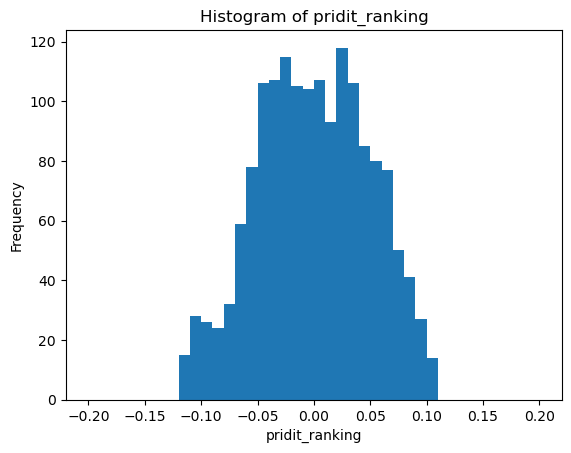

In [70]:
plt.hist(pridit_zscore['pridit_ranking'], bins=40, range=[-0.2, 0.2])
# threshold
# plt.axvline(x=threshold, color='red', linestyle='--')
plt.title(f'Histogram of pridit_ranking')
plt.xlabel('pridit_ranking')
plt.ylabel('Frequency')
plt.show()

In [71]:
threshold = len(flagged_Zscore) 
flagged_pridit_zscore = pridit_zscore.sort_values(by='pridit_ranking',ascending = True)[:threshold]
flagged_pridit_zscore

,Ticker,WC/TA,RE/TA,BV/TL,EBIT/TA,zscore,pridit_ranking
1584,X77,-2.43502,-4.33844,-0.66567,-0.22438,-29.07385,-0.11480
59,ATA,-2.43502,-4.33844,-0.66567,-0.19327,-28.86482,-0.11442
884,NOS,-2.43502,-4.33844,-0.66567,-0.16698,-28.68814,-0.11423
449,FPC,-2.43502,-4.33844,-0.66567,-0.16104,-28.64820,-0.11420
1551,VST,-2.43502,-3.31993,-0.66567,-0.20433,-25.61878,-0.11389
1546,VSG,-1.74845,-1.88345,-0.57567,-0.18060,-16.17798,-0.11265
997,PPI,-0.69943,-2.80229,-0.34913,-0.22438,-12.34816,-0.11228
724,L44,-0.92340,-1.34019,-0.47137,-0.22438,-9.17930,-0.11170
472,GGG,-2.43502,-4.09145,-0.66567,-0.05581,-27.13585,-0.11154
1230,STT,-1.24066,-3.32678,-0.36684,-0.08835,-16.71291,-0.11123


In [72]:
with pd.ExcelWriter('./data/score_raw.xlsx', engine='xlsxwriter') as writer:
    pridit_mscore.to_excel(writer, sheet_name='pridit_Mscore', index=False)
    pridit_fscore.to_excel(writer, sheet_name='pridit_Fscore', index=False)
    pridit_zscore.to_excel(writer, sheet_name='pridit_Zscore', index=False)

In [73]:
from openpyxl import load_workbook

def append_df_to_excel(filename, df, sheet_name):
    with pd.ExcelWriter(filename, engine='openpyxl', mode='a') as writer:
        writer.book = load_workbook(filename)
        df.to_excel(writer, sheet_name=sheet_name, index=False)

append_df_to_excel('./data/flagged_list.xlsx', flagged_pridit_mscore, 'pridit_Mscore')
append_df_to_excel('./data/flagged_list.xlsx', flagged_pridit_fscore, 'pridit_Fscore')
append_df_to_excel('./data/flagged_list.xlsx', flagged_pridit_zscore, 'pridit_Zscore')

/var/folders/x2/1k_rr05n63n6yyy4gcwt7lg80000gn/T/ipykernel_1398/1275773904.py:5: FutureWarning: Setting the `book` attribute is not part of the public API, usage can give unexpected or corrupted results and will be removed in a future version
  writer.book = load_workbook(filename)


# Evaluation

There are 2 methods:
- Method 1 "same": we might wanna take the same number of firms as flagged by its pre-trained score.
- Method 2 "top30": we might wanna take out only the top 30 firms

In [74]:
def check_overlapping(pridit_score, flagged_score, score_name, method, ver='none'):
    print("The method is: ", method)
    if method == "same":
        print("Number of flagged firms by pre-trained score model", len(flagged_score))
        flagged_pridit_score = pridit_score.sort_values(by='pridit_ranking',ascending = True)[:len(flagged_score)]
    elif method == "top30":
        flagged_pridit_score = pridit_score.sort_values(by='pridit_ranking',ascending = True)[:30]
    
    if score_name == 'mscore':
        overlap_score = flagged_pridit_score[flagged_pridit_score[score_name] > -1.78]
    elif score_name == 'fscore':
        if ver == 'high':
            overlap_score = flagged_pridit_score[flagged_pridit_score[score_name] > 1.85]
        if ver == 'moderate':
            overlap_score = flagged_pridit_score[flagged_pridit_score[score_name] > 1]
    elif score_name == 'zscore':
        overlap_score = flagged_pridit_score[flagged_pridit_score[score_name] < 1.1]
    
    print("Number of overlapping firms", len(overlap_score))
    print("Percentage of overlapping firms", len(overlap_score)/ len(flagged_pridit_score))
    return overlap_score

In [75]:
overlap_mscore_1 = check_overlapping(pridit_mscore, flagged_Mscore, 'mscore', 'same')
print()
overlap_mscore_2 = check_overlapping(pridit_mscore, flagged_Mscore, 'mscore', 'top30')

The method is:  same
Number of flagged firms by pre-trained score model 133
Number of overlapping firms 54
Percentage of overlapping firms 0.40601503759398494

The method is:  top30
Number of overlapping firms 21
Percentage of overlapping firms 0.7


In [76]:
overlap_fscore_1 = check_overlapping(pridit_fscore, flagged_Fscore, 'fscore', 'same', 'high')
print()
overlap_fscore_2 = check_overlapping(pridit_fscore, flagged_Fscore, 'fscore', 'top30', 'high')

The method is:  same
Number of flagged firms by pre-trained score model 49
Number of overlapping firms 12
Percentage of overlapping firms 0.24489795918367346

The method is:  top30
Number of overlapping firms 9
Percentage of overlapping firms 0.3


In [77]:
flagged_Fscore_mod = df_Fscore[df_Fscore['fscore'] > 1].sort_values(by='fscore', ascending=False,ignore_index=True)
print(len(flagged_Fscore_mod))
print(len(flagged_Fscore_mod) / len(df_Fscore))
flagged_Fscore_mod.head()

134
0.08390732623669381


,Ticker,RSST,REC,INV,SOFTASSETS,CASHSALES,ROA,ISSUE,pre_val,fscore
0,SDA,-0.42893,0.09069,0.01764,0.76470,451.53397,-0.07202,0,70.81029,270.27027
1,CH5,-0.03612,-0.01086,0.01824,0.68308,445.95078,0.01171,0,69.67135,270.27027
2,AMD,-0.00248,0.08767,-0.05810,0.90585,203.56815,0.00445,0,28.85530,270.27027
3,PIV,0.00961,0.14528,0.00000,0.99054,174.44788,0.00503,0,24.26659,270.27027
4,TTZ,-0.00303,0.02331,-0.03283,0.82826,115.08257,-0.07289,0,13.51036,270.26990


In [78]:
overlap_fscore_1_mod = check_overlapping(pridit_fscore, flagged_Fscore_mod, 'fscore', 'same', 'moderate')
print()
overlap_fscore_2_mod = check_overlapping(pridit_fscore, flagged_Fscore_mod, 'fscore', 'top30', 'moderate')

The method is:  same
Number of flagged firms by pre-trained score model 134
Number of overlapping firms 77
Percentage of overlapping firms 0.5746268656716418

The method is:  top30
Number of overlapping firms 27
Percentage of overlapping firms 0.9


In [79]:
overlap_zscore_1 = check_overlapping(pridit_zscore, flagged_Zscore, 'zscore', 'same')
print()
overlap_zscore_2 = check_overlapping(pridit_zscore, flagged_Zscore, 'zscore', 'top30')

The method is:  same
Number of flagged firms by pre-trained score model 94
Number of overlapping firms 69
Percentage of overlapping firms 0.7340425531914894

The method is:  top30
Number of overlapping firms 30
Percentage of overlapping firms 1.0
